<a href="https://colab.research.google.com/github/egorwar/DiffusionPractice/blob/main/Forward_Diffusion_Process_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

by Fedorov Georgii

In [ ]:
import os
import scipy
import urllib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

seed = 1234
np.random.seed(seed)
plt.style.use("seaborn")

<ipython-input-1-080f5bf69d46>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


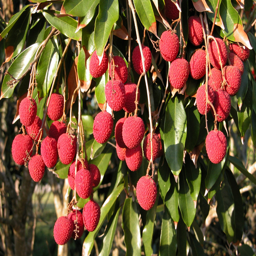

In [ ]:
# 1. download sample image
urllib.request.urlretrieve(
    "https://www.st-montaj.ru/wp-content/uploads/2022/05/kitajskie-lichi-foto-vkus-i-kak-vyrastit-4faff8d.jpg",
    "lichi.jpg"
)
img = Image.open("lichi.jpg").resize((256, 256))
img

In [ ]:
# 2. set timesteps & generate schedule
timesteps = 100
beta = np.linspace(0.0001, 0.05, num = timesteps, dtype=np.float32)
np.set_printoptions(precision=4, suppress=True)
beta

array([0.0001, 0.0006, 0.0011, 0.0016, 0.0021, 0.0026, 0.0031, 0.0036,
       0.0041, 0.0046, 0.0051, 0.0056, 0.0061, 0.0067, 0.0072, 0.0077,
       0.0082, 0.0087, 0.0092, 0.0097, 0.0102, 0.0107, 0.0112, 0.0117,
       0.0122, 0.0127, 0.0132, 0.0137, 0.0142, 0.0147, 0.0152, 0.0157,
       0.0162, 0.0167, 0.0172, 0.0177, 0.0182, 0.0187, 0.0193, 0.0198,
       0.0203, 0.0208, 0.0213, 0.0218, 0.0223, 0.0228, 0.0233, 0.0238,
       0.0243, 0.0248, 0.0253, 0.0258, 0.0263, 0.0268, 0.0273, 0.0278,
       0.0283, 0.0288, 0.0293, 0.0298, 0.0303, 0.0308, 0.0314, 0.0319,
       0.0324, 0.0329, 0.0334, 0.0339, 0.0344, 0.0349, 0.0354, 0.0359,
       0.0364, 0.0369, 0.0374, 0.0379, 0.0384, 0.0389, 0.0394, 0.0399,
       0.0404, 0.0409, 0.0414, 0.0419, 0.0424, 0.0429, 0.0434, 0.044 ,
       0.0445, 0.045 , 0.0455, 0.046 , 0.0465, 0.047 , 0.0475, 0.048 ,
       0.0485, 0.049 , 0.0495, 0.05  ], dtype=float32)

In [ ]:
# 3. prepare image output & input
processed_images = []
img_t = np.asarray(img.copy(), dtype=np.float32)
img_t

array([[[ 51.,  53.,  25.],
        [123.,  97.,  72.],
        [213., 166., 118.],
        ...,
        [109., 102.,  50.],
        [129., 116.,  68.],
        [140., 136.,  83.]],

       [[ 40.,  41.,  34.],
        [ 88.,  74.,  52.],
        [181., 141.,  94.],
        ...,
        [ 85.,  69.,  32.],
        [169., 123.,  78.],
        [172., 134.,  87.]],

       [[ 34.,  38.,  31.],
        [ 62.,  57.,  43.],
        [147., 112.,  76.],
        ...,
        [ 87.,  71.,  59.],
        [154., 113.,  76.],
        [211., 156., 111.]],

       ...,

       [[ 24.,  24.,  18.],
        [ 27.,  28.,  21.],
        [ 20.,  23.,  18.],
        ...,
        [ 28.,  38.,  17.],
        [ 51.,  56.,  29.],
        [ 73.,  74.,  56.]],

       [[ 14.,  15.,  10.],
        [ 17.,  18.,  13.],
        [ 20.,  20.,  17.],
        ...,
        [ 40.,  55.,  17.],
        [ 65.,  76.,  29.],
        [ 70.,  73.,  48.]],

       [[  9.,  10.,   7.],
        [ 10.,  11.,   8.],
        [ 13.,  

In [ ]:
# 4. normalize to [0, 1]
img_t /= 255
img_t

array([[[0.2   , 0.2078, 0.098 ],
        [0.4824, 0.3804, 0.2824],
        [0.8353, 0.651 , 0.4627],
        ...,
        [0.4275, 0.4   , 0.1961],
        [0.5059, 0.4549, 0.2667],
        [0.549 , 0.5333, 0.3255]],

       [[0.1569, 0.1608, 0.1333],
        [0.3451, 0.2902, 0.2039],
        [0.7098, 0.5529, 0.3686],
        ...,
        [0.3333, 0.2706, 0.1255],
        [0.6627, 0.4824, 0.3059],
        [0.6745, 0.5255, 0.3412]],

       [[0.1333, 0.149 , 0.1216],
        [0.2431, 0.2235, 0.1686],
        [0.5765, 0.4392, 0.298 ],
        ...,
        [0.3412, 0.2784, 0.2314],
        [0.6039, 0.4431, 0.298 ],
        [0.8275, 0.6118, 0.4353]],

       ...,

       [[0.0941, 0.0941, 0.0706],
        [0.1059, 0.1098, 0.0824],
        [0.0784, 0.0902, 0.0706],
        ...,
        [0.1098, 0.149 , 0.0667],
        [0.2   , 0.2196, 0.1137],
        [0.2863, 0.2902, 0.2196]],

       [[0.0549, 0.0588, 0.0392],
        [0.0667, 0.0706, 0.051 ],
        [0.0784, 0.0784, 0.0667],
        .

In [ ]:
# 6. try scheduled forward process

def forward(img_t_minus_1, beta, t):

    # 1. get beta_t, reshape to image dimensionality
    beta_t = beta[t]

    # 2. calculate mean and variance for img_t sampling
    mu = np.sqrt(1 - beta_t) * img_t_minus_1    # move the distribution's mean a bit closer to 0
    sigma = np.sqrt(beta_t)                     # make the distribution a bit wider

    # TODO: why sqrt prevents dimming?

    # 3. obtain imgage at timestep t
    img_t = mu + sigma * np.random.randn(*img_t_minus_1.shape)

    return img_t

In [ ]:
# nothing changes, reshaping just for compatibility:
print(f"0th beta: \t\t   {'{0:.4f}'.format(beta[0])}")
print(f"0th beta reshaped: \t{beta[0].reshape(-1, 1, 1)}")

0th beta: 		   0.0001
0th beta reshaped: 	[[[0.0001]]]


In [ ]:
# 4. run the forward process
for t in range(timesteps):
    img_t = forward(img_t, beta, t)
    if t%20==0 or t==timesteps-1:
        sample = (img_t.clip(0, 1) * 255.).astype(np.uint8)
        processed_images.append(sample)

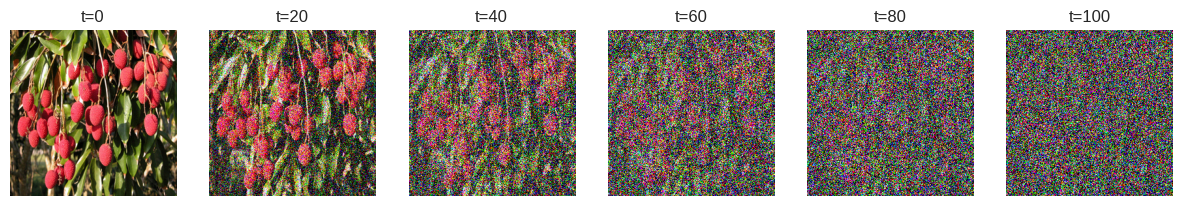

In [ ]:
# 5. plot the processed images

_, ax = plt.subplots(1, len(processed_images), figsize=(15, 6))

for i, sample in enumerate(processed_images):
    ax[i].imshow(sample)
    ax[i].set_title(f"t={i*20}")
    ax[i].axis("off")
    ax[i].grid(False)

# plt.suptitle("Forward process", y=0.75)
plt.show()

In [ ]:
# def forward_unsceduled(img_t_minus_1):
#     # 1. calculate mean and variance for img_t sampling
#     mu = img_t_minus_1
#     sigma = 0.05

#     # 3. obtain imgage at timestep t
#     img_t = mu + sigma * np.random.randn(*img_t_minus_1.shape)

#     return img_t

# # 3. perpare image output & input
# processed_images = []
# img_t = np.asarray(img.copy(), dtype=np.float32) / 255  # normalize to [0, 1]

# # 4. run the forward process
# for t in range(2000):
#     img_t = forward_unsceduled(img_t)
#     if t%400==0 or t==timesteps-1:
#         sample = (img_t.clip(0, 1) * 255.).astype(np.uint8)
#         processed_images.append(sample)

# # 5. plot the processed images

# _, ax = plt.subplots(1, len(processed_images), figsize=(15, 6))

# for i, sample in enumerate(processed_images):
#     ax[i].imshow(sample)
#     ax[i].set_title(f"t={i*400}")
#     ax[i].axis("off")
#     ax[i].grid(False)

# plt.suptitle("Forward process", y=0.75)
# plt.show()

In [ ]:
def forward_alpha(img, alpha_bar, t):

    # 1. get alpha_bar, reshape to image dimensionality
    alpha_bar_t = alpha_bar[t]

    # 2. calculate mean and variance for img_t sampling
    mu = np.sqrt(alpha_bar_t) * img
    sigma = np.sqrt(1. - alpha_bar_t)

    # 3. obtain imgage at timestep t
    img_t = mu + sigma * np.random.randn(*img.shape)

    return img_t

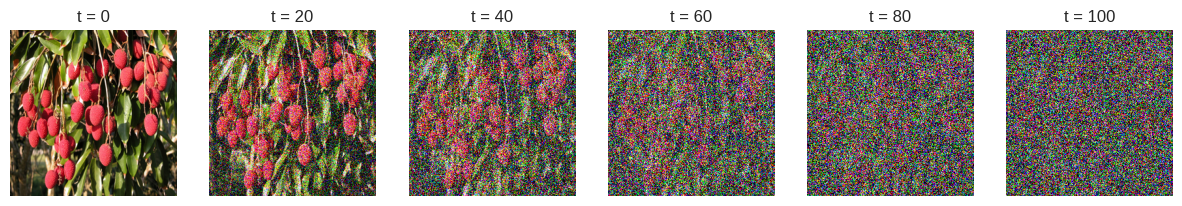

In [ ]:
alpha = 1 - beta
alpha_bar = np.cumprod(alpha)
processed_images = [img]

specific_timesteps = [19, 39, 59, 79, 99]
orig_img = np.asarray(img.copy(), dtype=np.float32) / 255.

for step in specific_timesteps:
    img_t = forward_alpha(orig_img, alpha_bar, step)
    img_t = (img_t.clip(0, 1) * 255.0).astype(np.uint8)
    processed_images.append(img_t)


# 3. Plot and see samples at different timesteps
_, ax = plt.subplots(1, len(processed_images), figsize=(15, 6))

for i, sample in enumerate(processed_images):
    ax[i].imshow(sample)
    ax[i].set_title(f"t = {i*20}")
    ax[i].axis("off")
    ax[i].grid(False)

# plt.suptitle("Efficient Forward process in DDPMs", y=0.75)
plt.show()
plt.close()